In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn
import numpy as np
import sys
import os
import re

seaborn.set(font_scale=1.5,style='ticks')

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append("/Users/yves/Downloads/jPCA-master/")

In [3]:
"""def fit(self,
            datas,
            pca=True,
            num_pcs=6, 
            subtract_cc_mean=True,
            tstart=0,
            tend=-1,
            times=None,
            align_axes_to_data=True,
            **preprocess_kwargs):"""
print()

# Linear algebra testing 

### Shear tranformation 

In [4]:
a = np.array([1,2])
M = np.array([[1,0],[1,1]])

In [5]:
for i in range(10):
    print(a)
    a = np.dot(M,a)

[1 2]
[1 3]
[1 4]
[1 5]
[1 6]
[1 7]
[1 8]
[1 9]
[ 1 10]
[ 1 11]


(-5, 5)

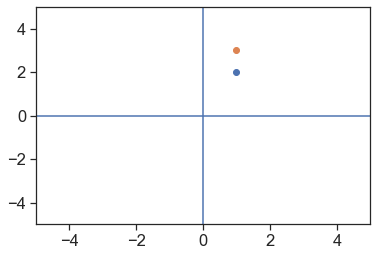

In [6]:
a = np.array([1,2])
plt.scatter(a[0],a[1])
a = np.dot(M,a)
plt.scatter(a[0],a[1])
plt.axhline(y=0)
plt.axvline(x=0)
plt.xlim(-5,5)
plt.ylim(-5,5)

## build matrix jordan form

In [7]:
def get_transition_matrix_for_sim(n=8):
    """ This function builds block diagon"""
    #get blocks with 0 norm
    
    ndim = n //2
    tmp = np.random.uniform(0,1,size=(ndim,2))
    tmp /= np.linalg.norm(tmp,axis=1)[:,None]
    
    M = np.zeros([n,n])
    for i,db in enumerate(construct_diagonal_blocks(tmp)):
        M[i*2:(i+1)*2,i*2:(i+1)*2] = db
        
    #note that the eigenvalues of the transition
    #matrix here are the eigenvalues of M
    A = np.random.uniform(size=(n,n))
    transition_matrix = np.dot(A,M).dot(np.linalg.inv(A))
    
    return transition_matrix

In [8]:
#tmp = np.random.uniform(0,1,size=(4,2))
#tmp /= np.linalg.norm(tmp,axis=1)[:,None]

In [9]:
#[a, -b]
#[b, a]
def construct_diagonal_blocks(vals):
    """ 
    https://math.stackexchange.com/questions/1345694/algorithm-for-real-matrix-given-the-complex-eigenvalues/1345699#1345699
    https://math.stackexchange.com/questions/3218954/construct-a-real-matrix-for-given-complex-eigenvalues
    """
    arrs = []
    for v in vals:
        arr = np.zeros([2,2])
        arr[0,0] = v[0]
        arr[0,1] = -v[1]
        arr[1,0] = v[1]
        arr[1,1] = v[0]
        arrs.append(arr)
    return np.array(arrs)

def fill_diagonal_blocks(arrs):
    return None

In [10]:
from scipy.optimize import minimize

def skew_sym_regress(X, X_dot, tol=1e-8):
    """
    Original data tensor is C x L x N where N is number of Neurons, L is length of each trial
    and C is number of conditions. We stack this to get L*C x N array.
    Args
    ----
    X_dot: First difference of (reduced dimension) data. Shape is T x N

    X: reduced dimension data. Shape is T x N
    """

    # 1) Initialize h using the odd part of the least-squares solution.
    # 2) call scipy.optimize.minimize and pass in our starting h, and x_dot, 
    T, N = X.shape
    M_lstq, _, _, _ = np.linalg.lstsq(X, X_dot, rcond=None)
    M_lstq = M_lstq.T
    M_init = 0.5 * (M_lstq - M_lstq.T)
    h_init = _reshape_mat2vec(M_init, N)

    options=dict(maxiter=10000, gtol=tol)
    result = minimize(lambda h: _objective(h, X, X_dot),
                    h_init,
                    jac=lambda h: _grad_f(h, X, X_dot),
                    method='CG',
                    options=options)
    if not result.success:
        print("Optimization failed.")
        print(result.message)
    M = _reshape_vec2mat(result.x, N)
    assert(np.allclose(M, -M.T))
    return M

In [11]:

def _grad_f(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    dM = (X.T @ X @ M.T) - X.T @ X_dot
    return _reshape_mat2vec(dM.T - dM, N)


def _objective(h, X, X_dot):
    _, N = X.shape
    M = _reshape_vec2mat(h, N)
    return 0.5 * np.linalg.norm(X @ M.T - X_dot, ord='fro')**2


def _reshape_vec2mat(h, N):
    M = np.zeros((N, N))
    upper_tri_indices = np.triu_indices(N, k=1)
    M[upper_tri_indices] = h
    return M - M.T


def _reshape_mat2vec(M, N):
    upper_tri_indices = np.triu_indices(N, k=1)
    return M[upper_tri_indices]

# NOTE TO FUTURE SELF, CONSTRUCT A SIMPLER ROTATION MATRIX THAT ONLY ROTATES ON A 2D PLANE IN R^N

# Clean version

In [12]:
qorth,roth = np.linalg.qr(np.random.normal(size=(3,3)))

In [13]:
nDim = 16
A = get_transition_matrix_for_sim(nDim)#  + np.random.normal(scale=.1,size=(3,3))

In [14]:
nDim = 4
nDim2= 4
theta = np.pi/4
#A = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
A = np.array([[np.cos(theta),-np.sin(theta),0,0],
              [np.sin(theta),np.cos(theta),0,0],
              [np.random.uniform(-1,1),np.random.uniform(-1,1),np.random.uniform(-1,1),np.random.uniform(-1,1)],
              [np.random.uniform(-1,1),np.random.uniform(-1,1),0,1]])

In [452]:
tmp1 = np.random.normal(size=(nDim,nDim2))
#assert np.linalg.matrix_rank(tmp1)==3
#invtmp1 = np.linalg.inv(np.dot(tmp1.T,tmp1))
P = np.dot(tmp1,np.linalg.inv(np.dot(tmp1.T,tmp1))).dot(tmp1.T)
#qorth = np.dot(qorth,qorth.T)

In [453]:
qorth

array([[-0.79612965, -0.3961599 , -0.2441065 ,  0.38684226],
       [ 0.17169279, -0.87104993,  0.18795381, -0.42007971],
       [ 0.50345983, -0.27354376,  0.0924588 ,  0.8143423 ],
       [-0.28849155,  0.09748415,  0.94685625,  0.10359882]])

In [454]:
#A = np.dot(P[:,:3],A)

In [455]:
qorth,rorth = np.linalg.qr(tmp1)

In [456]:
#nDim2 = 5

state0 = np.random.normal(size=(nDim,1))

In [617]:
state_representation.shape

(4, 9)

In [457]:
n_states = 9
state_representation = [state0.copy()]
state_noise = np.random.normal(size=(2,nDim2))
for _ in range(1,n_states):
    tmp = np.dot(A,state_representation[-1])
    state_representation.append(tmp.copy())
    
#this is now n_states n_timepoints 
state_representation = np.hstack(state_representation) 
#state_representation += .1*np.random.normal(size=(n_states,2)).dot(state_noise).T

In [458]:
#state_representation = np.dot(rorth,state_representation)

In [467]:
sr2.shape

(64, 9)

In [525]:
state_representation.shape

(4, 9)

In [596]:
shuff_ccs = []
for _ in range(10000):
    y = sr2[:,np.random.permutation(np.arange(9))].T
    #y = sr2.T
    X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
    b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
    binv = np.linalg.pinv(b)

    evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
    shuff_ccs.append(evar)

In [597]:
shuff_ccs = []
for _ in range(10000):
    y = sr2[:,np.random.permutation(np.arange(9))].T
    #y = sr2.T
    X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
    b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
    binv = np.linalg.pinv(b)

    evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
    shuff_ccs.append(evar)

y = sr2.T
X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
binv = np.linalg.pinv(b)

true_evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
print(true_evar)


0.6985929305401248


In [599]:
import scipy.stats as stt

In [601]:
stt.percentileofscore(shuff_ccs,true_evar)

99.75

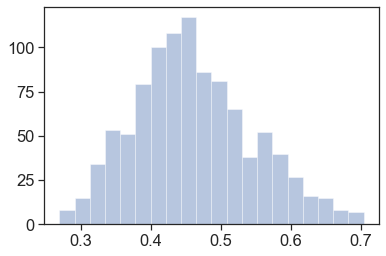

In [594]:
seaborn.distplot(shuff_ccs,kde=0)

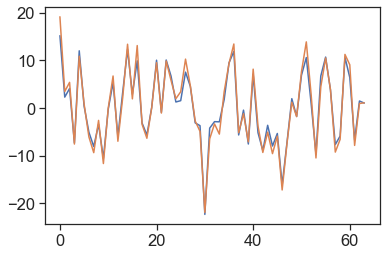

In [572]:
plt.plot(np.dot(X,b)[0])
plt.plot(y[0])

In [573]:
X.shape

(9, 5)

In [574]:
X.shape

(9, 5)

In [575]:
y.shape

(9, 64)

In [576]:
residuals

array([], dtype=float64)

In [577]:
np.sum((y-np.mean(y,axis=0))**2,axis=0)

array([ 995.95238527,  553.68292629,  432.12503093,  370.40530825,
        630.08667005,  115.08337121,  268.8768894 ,  227.84429465,
        280.41331399,  354.62778273,  151.1113179 ,  924.90934588,
        143.51498741,  177.54801438,  332.46527884,  195.90310976,
        261.85750158,   79.13107701,  123.36806347,   74.36307782,
        999.79216738,  160.98953582,  335.1021476 ,  155.21699082,
        308.72068802,  253.78421625,  295.31477244,  341.78153207,
        310.95514147,  378.46769459,  931.29221366,  232.03300486,
         99.75199217, 1112.7756265 ,  158.75107311,  228.83511771,
        935.1629058 ,  230.36466661,   84.21857866,  636.23116656,
        733.47299863,  236.13502458,  151.8095464 ,  149.47891364,
        169.01598108,  435.82847448,  961.42284306,  300.63153968,
        104.68587407,  133.84352564,  275.51980445, 1166.09380278,
        137.31362121,  314.11321293,  996.63475388,   79.54077034,
        456.90607057,  147.05576066,  208.31151621,  421.18275

In [578]:
1-np.mean(residuals/np.sum((y-np.mean(y,axis=0))**2,axis=0))

ValueError: operands could not be broadcast together with shapes (0,) (64,) 

In [489]:
np.sum(y.var(axis=0))

array([110.66137614,  61.52032514,  48.01389233,  41.15614536,
        70.00963001,  12.78704125,  29.87520993,  25.31603274,
        31.15703489,  39.40308697,  16.79014643, 102.7677051 ,
        15.94610971,  19.72755715,  36.94058654,  21.7670122 ,
        29.09527795,   8.79234189,  13.70756261,   8.2625642 ,
       111.0880186 ,  17.8877262 ,  37.23357196,  17.24633231,
        34.30229867,  28.19824625,  32.81275249,  37.97572579,
        34.55057127,  42.05196607, 103.47691263,  25.78144498,
        11.08355469, 123.64173628,  17.63900812,  25.42612419,
       103.90698953,  25.59607407,   9.35761985,  70.69235184,
        81.49699985,  26.23722495,  16.86772738,  16.60876818,
        18.77955345,  48.42538605, 106.82476034,  33.40350441,
        11.63176379,  14.87150285,  30.61331161, 129.56597809,
        15.25706902,  34.9014681 , 110.73719488,   8.83786337,
        50.76734117,  16.33952896,  23.14572402,  46.79808336,
        40.53561644,  18.52174554,  15.52977539,   4.51

In [480]:
residuals

array([620.47673962, 418.87360266, 264.47629629, 322.93442416,
       609.14578929, 109.87410972, 247.29010856, 118.74543784,
       201.80096788, 240.60847126, 134.00467846, 788.17511692,
        81.49658675, 126.00364762, 305.13415204, 142.75576097,
       231.17731522,  70.57858072,  45.67708473,  28.06402046,
       517.29795961,  66.51863114, 245.10153208, 136.31866073,
       209.34650143, 216.66967253, 251.13866173, 335.17669072,
       253.81058286, 292.34070003, 796.00873413, 136.31450374,
        72.66537909, 978.8013921 , 148.77519739, 107.33880778,
       806.25148615, 144.65872637,  33.60538212, 472.55976749,
       594.99948231, 185.9841913 , 144.39381514, 139.89522577,
       122.18571245, 395.45538715, 914.74269495, 263.2362842 ,
        92.57350061, 101.77806307, 253.46309859, 923.41475424,
       103.8456671 , 122.53275308, 920.89145781,  52.32283993,
       261.35579924, 127.75429615, 125.31809721, 392.43482541,
       335.72631883, 138.06772101,  69.98383285,  34.13

In [475]:
#binv = np.linalg.pinv(b)

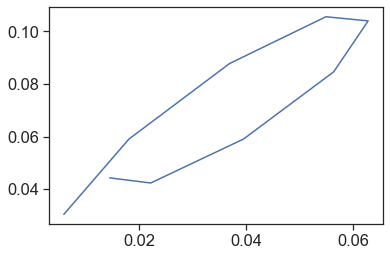

In [462]:
binv = np.linalg.pinv(b)

plt.plot(binv.dot(state_representation)[0],binv.dot(state_representation)[1])

In [463]:
prediction = np.dot(state_representation.T,b)

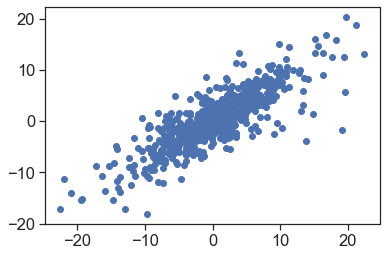

In [464]:
plt.scatter(sr2.T.flatten(),prediction.flatten())
#plt.scatter(prediction.flatten())

In [389]:
U,S,Vt = np.linalg.svd(np.dot(state_representation.T,b).T)

In [390]:
Vt.shape

(9, 9)

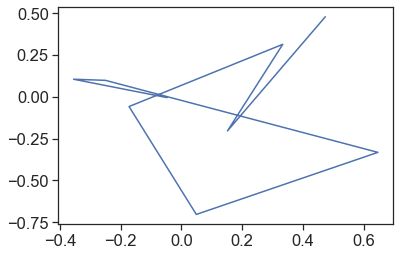

In [391]:
ix = 1
plt.plot(Vt[:,2*ix],Vt[:,2*ix+1])

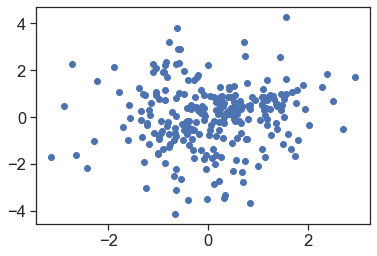

In [392]:
plt.scatter(W.flatten(),b.flatten())

In [393]:
b.shape

(4, 64)

In [394]:
W.shape

(4, 64)

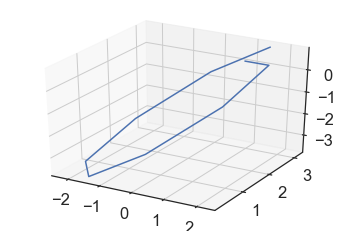

In [395]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(state_representation[0],state_representation[2],state_representation[3])

In [396]:
from sklearn.decomposition import PCA
datas = [state_representation.copy().T]
#datas = datas.reshape(1,9,4)
soft_normalize = 5
subtract_cc_mean = False
times = list(range(9))
tstart = 0
tend = max(times)
pca = True
num_pcs = 2

In [397]:
W.shape

(4, 64)

In [398]:
b.shape

(4, 64)

In [399]:
state_representation.shape

(4, 9)

In [612]:
n_neurons = 140
W = np.random.normal(size=(4,n_neurons))
sr2 = np.dot(state_representation.T,W).T + 3*np.dot(np.random.normal(size=(9,6)),np.random.normal(size=(6,n_neurons))).T
#sr2 = state_representation
datas = [sr2.T]
times = list(range(sr2.shape[1]))
tstart = 0
tend = sr2.shape[1]-1

In [613]:
shuff_ccs = []
for _ in range(10000):
    y = sr2[:,np.random.permutation(np.arange(9))].T
    #y = sr2.T
    X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
    b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
    binv = np.linalg.pinv(b)

    evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
    shuff_ccs.append(evar)

y = sr2.T
X = np.hstack([np.ones([1,9]).T,state_representation.T.copy()])
b,residuals,rank,singular_vals = np.linalg.lstsq(X,y,rcond=None)
binv = np.linalg.pinv(b)

true_evar = 1-np.var(np.dot(X,b)-y)/np.var(y)
print(true_evar)


0.5840951403976705


In [614]:
stt.percentileofscore(shuff_ccs,true_evar)

95.43

In [615]:
%matplotlib inline

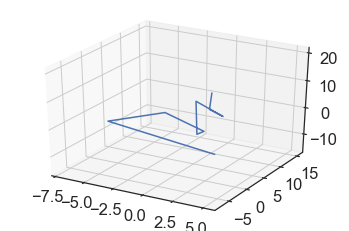

In [443]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(sr2[12],sr2[1],sr2[33])

In [444]:
from jPCA import JPCA

jpca = JPCA(num_jpcs=6)

(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt,_) = jpca.fit([datas[0][:,np.random.permutation(np.arange(9))]], times=times, tstart=tstart, tend=tend,
                             subtract_cc_mean=False,
                             pca=False,
                             soft_normalize=False,
                             align_axes_to_data=False)


In [445]:
np.sum(jpca_var_capt)/jpca.full_data_var

0.5729518593786801

In [446]:
jpca_var_capt/jpca.full_data_var

array([0.00964637, 0.0211617 , 0.34453881, 0.13487672, 0.03854102,
       0.02418724])

In [447]:
jpca.full_data_var

430.49668778293193

In [448]:
projected = np.array(projected)

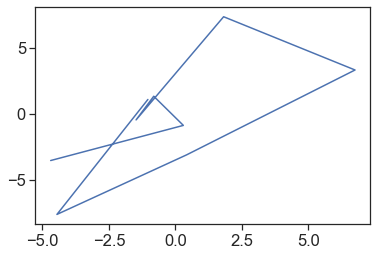

In [449]:
projected = np.array(projected)
plt.plot(projected[0,:,-1],projected[0,:,-2])

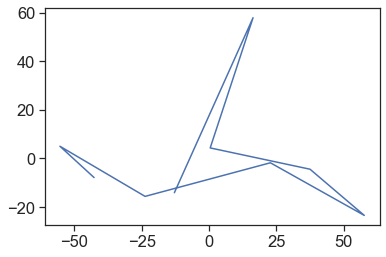

In [450]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)

projected_pca = pca.fit_transform(datas[0])
plt.plot(projected_pca[:,0],projected_pca[:,1])

In [451]:
projected_pca.shape

(9, 6)

In [437]:
nDim, len_sequence = state_representation.shape

In [438]:
state_representation.shape

(4, 9)

In [439]:
projected_pca.shape

(9, 6)

In [276]:
#Ahat = np.linalg.lstsq(state_representation[:,:-1].T,state_representation[:,1:].T)[0].T
Ahat = np.linalg.lstsq(projected_pca[:-1],projected_pca[1:])[0].T

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [277]:
state_representation.shape

(4, 9)

In [278]:
Ahat_skew = (Ahat - Ahat.T)/2

In [279]:
Ahat_symm = (Ahat + Ahat.T)/2

In [280]:
I = np.eye(len(Ahat_skew
              ))

In [281]:
Q = np.dot(np.linalg.inv(I+Ahat_skew),(I-Ahat_skew))
assert np.allclose(1,np.abs(np.linalg.eig(Q)[0]))

In [282]:
Qe, Qv = np.linalg.eig(Ahat_skew)

In [298]:
Qv.shape

(6, 6)

In [302]:
#ix = 2
a1 = (Qv[:,ix] + Qv[:,ix+1])
a2 = 1j*(Qv[:,ix] - Qv[:,ix+1])

In [300]:
proj = np.vstack([a1,a2])

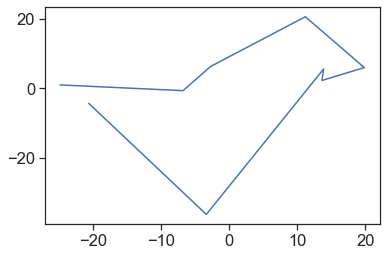

In [301]:
plt.plot(np.dot(proj,projected_pca.T)[0],np.dot(proj,projected_pca.T)[1])

In [122]:
qo1,ro1 = np.linalg.qr(Qv.real)
qo2,ro2 = np.linalg.qr(Qv.imag)

In [830]:
np.round(ro1,decimals=2)

array([[ 0.71,  0.71, -0.  ],
       [ 0.  ,  0.  ,  0.65],
       [ 0.  ,  0.  ,  0.76]])

In [831]:
np.round(ro2,decimals=2)

array([[-0.71,  0.71,  0.  ],
       [ 0.  , -0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ]])

In [842]:
Qe

array([0.87443656+0.48513988j, 0.87443656-0.48513988j,
       1.        +0.j        ])

In [832]:
import scipy.linalg as la


In [1281]:
t,z=la.schur(Ahat_skew, output='real', lwork=None, overwrite_a=False, sort=None, check_finite=True)

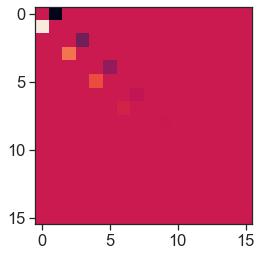

In [1284]:
plt.imshow(t)

In [1285]:
z

array([[-0.07493376,  0.07493376,  0.18855745, -0.00499244, -0.4487596 ,
        -0.4487596 , -0.16717812,  0.12604586, -0.31368267,  0.08900076,
        -0.02969599,  0.0574733 ,  0.07258595,  0.56382796,  0.26755617,
         0.03639533],
       [ 0.50937765, -0.33038632,  0.03894261, -0.28774394, -0.32539869,
        -0.04243366,  0.26239912, -0.10529847,  0.17346538, -0.36249984,
        -0.18034532, -0.05643015, -0.23687442, -0.06076406,  0.28851739,
         0.13853154],
       [ 0.41781959,  0.44203629, -0.25173628, -0.03500573,  0.17138424,
         0.10441431,  0.00280328, -0.21069199,  0.05351705,  0.43782205,
        -0.09931494,  0.3288682 , -0.00898334,  0.10491824,  0.31819642,
         0.23633199],
       [-0.07282981,  0.6340497 , -0.05416566,  0.01290589, -0.06355653,
        -0.0044554 ,  0.16062587,  0.05237805,  0.35655136, -0.28902952,
        -0.26712083, -0.46633799,  0.02719069,  0.22171633, -0.0865573 ,
        -0.00957473],
       [ 0.30498578,  0.15248843,  0

In [836]:
t[4:8,4:8]

array([], shape=(0, 0), dtype=float64)

In [837]:
#construct a matrix that 
C = np.vstack([Qv[:,1],Qv[:,2]]).T

P = np.dot(C,np.linalg.inv(np.dot(C.T,C))).dot(C.T)

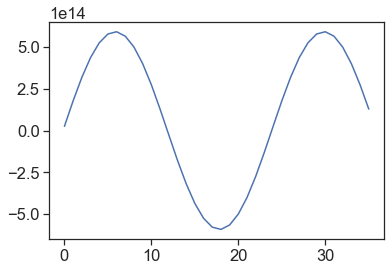

In [839]:
plt.plot((P@state_representation)[0])
#plt.plot((P@state_representation)[1])
#plt.plot((P@state_representation)[2])

In [284]:
P.shape

(2, 2)

In [285]:
state_representation.shape

(3, 36)

In [269]:
proj = Qv[:,1]@state_representation
proj2 = Qv[:,2]@state_representation

array([ 0.45904599-0.02221533j,  0.75762941+0.59137241j,
        0.8838179 +0.97515872j,  0.80636104+1.13425333j,
        0.54310608+1.03199837j,  0.15471105+0.69195497j,
       -0.2693318 +0.19247441j, -0.63131643-0.35135524j,
       -0.84783596-0.81422719j, -0.86900092-1.08948856j,
       -0.68993459-1.11371486j, -0.35189662-0.88132398j,
        0.06722379-0.44586237j,  0.47085479+0.09233284j,
        0.76599355+0.60925314j,  0.8846355 +0.98579205j,
        0.79944371+1.13518919j,  0.53004768+1.02302111j,
        0.13852044+0.6751331j , -0.28492405+0.17168395j,
       -0.64271763-0.37132385j, -0.85241909-0.82877287j,
       -0.86570997-1.09525977j, -0.67952783-1.10938181j,
       -0.33677194-0.86788508j,  0.08358143-0.42641415j,
        0.48467635+0.11330921j,  0.77409431+0.62692437j,
        0.88514893+0.99608643j,  0.7922515 +1.13573472j,
        0.51680704+1.0136921j ,  0.12228221+0.6580791j ,
       -0.30041834+0.15083446j, -0.65389784-0.39116479j,
       -0.85670913-0.84303359j,

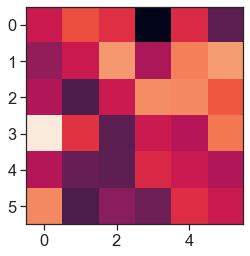

In [184]:
plt.imshow(Bhat.T)

In [183]:
Bhat = skew_sym_regress(state_representation[:,:-1].T,state_representation[:,1:].T)
#Bhat = skew_sym_regress(state_representation[:,1:].T,state_representation[:,:-1].T)

Optimization failed.
Desired error not necessarily achieved due to precision loss.


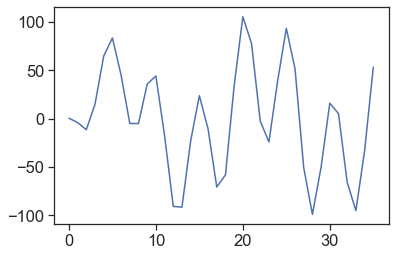

In [173]:
plt.plot(state_representation[0])

In [174]:
A == -A.T

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [161]:
np.dot(Bhat,state_representation[:,0])

array([0.08474763, 0.23167166, 0.17097971, 0.12963771, 0.04867101,
       0.2908652 ])

In [162]:
state_representation[:,1]

array([ 1.64542836, -0.66637245,  1.50099182,  0.4391805 ,  1.69688049,
        2.24497886])

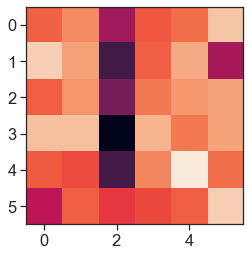

In [151]:
plt.imshow(Ahat)

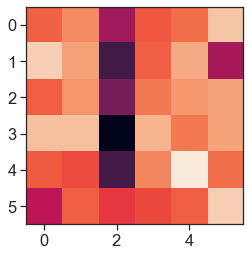

In [152]:
plt.imshow(A)

In [153]:
y1 = state_representation[:,:-1]
y2 = state_representation[:,1:]
Ahat =np.dot(y2,np.linalg.pinv(y1))

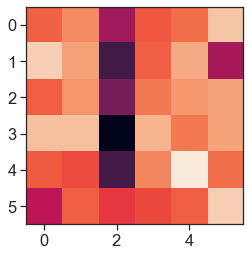

In [154]:
plt.imshow(Ahat)

# This is the simple case

In [64]:
M = np.zeros([8,8])
for i,db in enumerate(construct_diagonal_blocks(tmp)):
    M[i*2:(i+1)*2,i*2:(i+1)*2] = db

IndexError: index 1 is out of bounds for axis 0 with size 1

In [16]:
A = np.random.uniform(size=(8,8))

In [17]:
A = np.random.uniform(size=(8,8))
mat = np.dot(A,M).dot(np.linalg.inv(A))

In [ ]:
Ahh

In [18]:
n =8
initial_index = [3,0,2,1]
final_index = [0,1,3,2]
permutation_matrix = np.zeros((n, n), dtype=int)
permutation_matrix[final_index, initial_index] = 1


In [19]:
permutation_matrix

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
n_states = 9
n_units = 200

In [21]:
cell_correlations = np.random.normal(size=n_units)


In [22]:
rep0 = np.random.normal(size=500)

In [23]:
aa = np.outer(cell_correlations,rep0)


In [24]:
U,S,V = np.linalg.svd(aa)

In [25]:
#Y_t.shape = (nPCs,nTimepoiints)
#Y_(t+1).shape = (nPCs,nTimepoiints)

In [26]:
#A.shape = (nPcs x nPcs)

In [27]:
nPcs = 8

#A = np.random.normal(size=(nPcs,nPcs))
A = np.vstack([np.ones(n_states),np.zeros([n_states-1,n_states])])

In [28]:
A = np.eye(nPcs)
A = A[np.random.permutation(np.arange(nPcs))]

In [29]:
import numpy as np


k = nPcs
A = np.identity(k)

# Add a random drift term.  We can guarantee that the diagonal terms
#     will be larger by specifying a `high` parameter that is < 1.
# How much larger depends on that term.  Here, it is 0.25.
A = A + np.random.uniform(low=0., high=.5, size=(k, k))

# Lastly, divide by row-wise sum to normalize to 1.
A = A / A.sum(axis=1, keepdims=1)


In [30]:
import scipy.stats


In [31]:
tmp = np.random.uniform(0,1,[nPcs,2])
tmp /= np.sqrt(np.sum(tmp**2,axis=1))[:,None]

In [32]:
L = np.eye(nPcs)*np.sum(tmp*np.array([1,1j]),axis=1)
#L = np.eye(nPcs)
Q = scipy.stats.ortho_group.rvs(nPcs)

In [33]:
A= np.dot(Q,L).dot(Q.T)

In [34]:
state0 = np.random.normal(size=(nPcs,1))

In [35]:
A = mat

In [36]:
state_representation = [state0.copy()]
for _ in range(1,n_states):
    tmp = np.dot(A,state_representation[-1])
    state_representation.append(tmp.copy())
    
#this is now n_states n_timepoints 
state_representation = np.hstack(state_representation)

NameError: name 'I' is not defined

In [37]:
state0.T

array([[-0.00928161, -1.31979165, -1.23073869, -0.6306751 ,  1.82901741,
         0.63169166, -1.52506889, -0.33002468]])

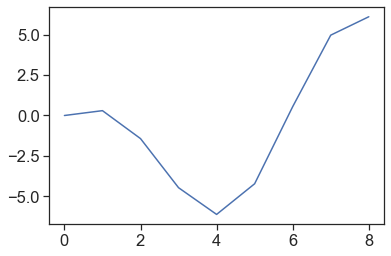

In [38]:
plt.plot(state_representation[0].real)

In [39]:
#sorting approach

In [40]:
y1 = state_representation[:,:-1]
y2 = state_representation[:,1:]

In [41]:
Ay0 = y1

In [43]:
state_representation[:,0]

array([-0.00928161, -1.31979165, -1.23073869, -0.6306751 ,  1.82901741,
        0.63169166, -1.52506889, -0.33002468])

In [44]:
np.linalg.pinv(state_representation[:,1].reshape(1,-1))

array([[ 0.04623451],
       [-0.15118985],
       [-0.04588375],
       [-0.15951777],
       [-0.00419884],
       [ 0.04450497],
       [-0.3070117 ],
       [-0.10235592]])

In [45]:
state_representation = np.random.uniform(size=(12,22))
n_states = state_representation[]

SyntaxError: invalid syntax (<ipython-input-45-5a44b6bf8832>, line 2)

In [46]:
tmp1 = np.zeros([len(state_representation[:,1])]*2)
for i in range(n_states-1):
    tmp1 += np.outer(state_representation[:,i+1],state_representation[:,i])

In [47]:
tmp2 = np.zeros([len(state_representation[:,1])]*2)
for i in range(n_states-1):
    tmp2 += np.outer(state_representation[:,i],state_representation[:,i])

In [42]:
np.linalg.inv()

TypeError: _unary_dispatcher() missing 1 required positional argument: 'a'

In [48]:
y1 = state_representation[:,:-1]
y2 = state_representation[:,1:]
Ahat =np.dot(y2,np.linalg.pinv(y1))

In [49]:
Ahat

array([[ 0.48820043,  0.68778021, -0.74983668, -1.42814413,  0.94448476,
        -1.20864679,  0.84042238,  0.91902328],
       [-1.67261961, -1.17338598,  1.67550531,  0.55164437, -0.45557277,
         2.89062859,  0.90881829, -0.87849774],
       [-1.09209484, -1.07484987,  1.52413566,  0.08862413, -0.02556401,
         1.57171653,  0.40001129,  0.36700122],
       [-0.42734893, -0.59394554,  0.34679938,  0.43708181, -0.20174576,
         0.98466192,  0.95974336, -0.37509723],
       [-1.03494841, -0.37984793,  0.12814358, -0.0034214 ,  1.11441001,
        -0.7978243 ,  1.14899092,  0.49614557],
       [-0.85547005, -0.28882837,  0.19212775, -0.19046103,  0.36863219,
         0.65237953,  0.69933199,  0.03995222],
       [-0.52520354, -0.03787736, -0.11325448, -0.85994692,  0.19516643,
        -0.69577084,  1.5323804 ,  0.74109147],
       [-0.88447925, -0.02972273, -0.01152337, -0.04953054,  0.27773034,
         0.0273873 ,  0.61816512,  0.96359183]])

In [50]:
state_representation[:,1]

array([ 0.29027467, -0.94921706, -0.2880725 , -1.00150235, -0.0263616 ,
        0.27941611, -1.92751527, -0.64262239])

In [51]:
Ahat

array([[ 0.48820043,  0.68778021, -0.74983668, -1.42814413,  0.94448476,
        -1.20864679,  0.84042238,  0.91902328],
       [-1.67261961, -1.17338598,  1.67550531,  0.55164437, -0.45557277,
         2.89062859,  0.90881829, -0.87849774],
       [-1.09209484, -1.07484987,  1.52413566,  0.08862413, -0.02556401,
         1.57171653,  0.40001129,  0.36700122],
       [-0.42734893, -0.59394554,  0.34679938,  0.43708181, -0.20174576,
         0.98466192,  0.95974336, -0.37509723],
       [-1.03494841, -0.37984793,  0.12814358, -0.0034214 ,  1.11441001,
        -0.7978243 ,  1.14899092,  0.49614557],
       [-0.85547005, -0.28882837,  0.19212775, -0.19046103,  0.36863219,
         0.65237953,  0.69933199,  0.03995222],
       [-0.52520354, -0.03787736, -0.11325448, -0.85994692,  0.19516643,
        -0.69577084,  1.5323804 ,  0.74109147],
       [-0.88447925, -0.02972273, -0.01152337, -0.04953054,  0.27773034,
         0.0273873 ,  0.61816512,  0.96359183]])

In [52]:
state_representation[:,0]

array([-0.00928161, -1.31979165, -1.23073869, -0.6306751 ,  1.82901741,
        0.63169166, -1.52506889, -0.33002468])

In [53]:
state0[:,0]

array([-0.00928161, -1.31979165, -1.23073869, -0.6306751 ,  1.82901741,
        0.63169166, -1.52506889, -0.33002468])

In [54]:
state_representation[:,1]

array([ 0.29027467, -0.94921706, -0.2880725 , -1.00150235, -0.0263616 ,
        0.27941611, -1.92751527, -0.64262239])

In [55]:
y1 = state_representation[:,:-1]
y2 = state_representation[:,1:]
Ahat =np.dot(y2,np.linalg.pinv(y1))

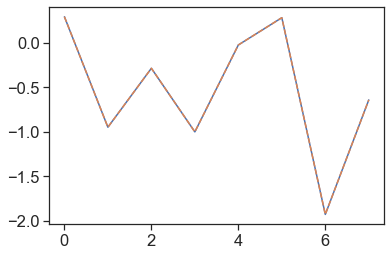

In [56]:
plt.plot(state_representation[:,1])
plt.plot(np.dot(Ahat,state0),linestyle='--')


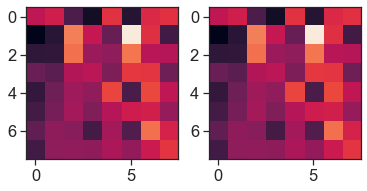

In [57]:
plt.subplot(1,2,1)
plt.imshow(A)
plt.subplot(1,2,2)
plt.imshow(Ahat)
#plt.colorbar()

In [58]:
A

array([[ 0.48820043,  0.68778021, -0.74983668, -1.42814413,  0.94448476,
        -1.20864679,  0.84042238,  0.91902328],
       [-1.67261961, -1.17338598,  1.67550531,  0.55164437, -0.45557277,
         2.89062859,  0.90881829, -0.87849774],
       [-1.09209484, -1.07484987,  1.52413566,  0.08862413, -0.02556401,
         1.57171653,  0.40001129,  0.36700122],
       [-0.42734893, -0.59394554,  0.34679938,  0.43708181, -0.20174576,
         0.98466192,  0.95974336, -0.37509723],
       [-1.03494841, -0.37984793,  0.12814358, -0.0034214 ,  1.11441001,
        -0.7978243 ,  1.14899092,  0.49614557],
       [-0.85547005, -0.28882837,  0.19212775, -0.19046103,  0.36863219,
         0.65237953,  0.69933199,  0.03995222],
       [-0.52520354, -0.03787736, -0.11325448, -0.85994692,  0.19516643,
        -0.69577084,  1.5323804 ,  0.74109147],
       [-0.88447925, -0.02972273, -0.01152337, -0.04953054,  0.27773034,
         0.0273873 ,  0.61816512,  0.96359183]])

In [59]:
np.linalg.eig(Ahat)

(array([0.46063911+0.88758752j, 0.46063911-0.88758752j,
        0.53414314+0.84539405j, 0.53414314-0.84539405j,
        0.90751681+0.42001576j, 0.90751681-0.42001576j,
        0.86709778+0.49813798j, 0.86709778-0.49813798j]),
 array([[-0.31439849-0.26294664j, -0.31439849+0.26294664j,
          0.32837125-0.24567588j,  0.32837125+0.24567588j,
         -0.36823497+0.17013591j, -0.36823497-0.17013591j,
          0.45600346+0.02956183j,  0.45600346-0.02956183j],
        [-0.46685154+0.j        , -0.46685154-0.j        ,
          0.42362716+0.j        ,  0.42362716-0.j        ,
         -0.36068588-0.16993256j, -0.36068588+0.16993256j,
          0.09179223+0.04237123j,  0.09179223-0.04237123j],
        [-0.2860419 -0.11953322j, -0.2860419 +0.11953322j,
          0.15913329-0.1864834j ,  0.15913329+0.1864834j ,
         -0.57438104+0.j        , -0.57438104-0.j        ,
          0.37203904-0.17942738j,  0.37203904+0.17942738j],
        [-0.43440745+0.03124838j, -0.43440745-0.03124838j,
    

In [300]:
state_representation2 = [state0]
for _ in range(1,n_states):
    tmp = np.dot(Ahat,state_representation2[-1])
    state_representation2.append(tmp.copy())
    
#this is now n_states n_timepoints 
state_representation2 = np.hstack(state_representation2)

In [301]:
assert np.allclose(state_representation,state_representation2)

In [302]:
np.dot(Ahat,state_representation[:,-1])

array([-0.72235655, -0.93675712, -1.12567984,  1.10369997])

In [ ]:
state_representation[:,]

In [303]:
np.dot(A,state_representation[:,-1])

array([-0.72235655, -0.93675712, -1.12567984,  1.10369997])

# Now tackle the complex case 


I think it just naively works to factor the time series

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA()